In [2]:
curve_db = load('Curve Database (Conductor < 100 000)/curve_database_c1_to_100000.sobj')

✓ curve_db is loaded with 437226 isogeny classes

Generating initial phi set in parallel...
Using 28 CPU cores


Generating phis: 100%|██████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 60.50it/s]


Initial phi set: 49980 (redundant) rational values
After removing duplicates: 2001 unique rational values

Processing phis...


Loading conductors: 100%|███████████████████████████████████████████████████████████| 2001/2001 [00:21<00:00, 94.24it/s]


Found 187 phis in database below 100,000 conductors, associated to distinct isogeny classes

Saving results...
Saved scan data to HV_curves_uniform/Nphi50000_phirange_-10_10_round2_phi_scan_data.sobj
Saved individual lists:
  - HV_curves_uniform/Nphi50000_phirange_-10_10_round2_phi_reps.sobj
  - HV_curves_uniform/Nphi50000_phirange_-10_10_round2_conductors.sobj
  - HV_curves_uniform/Nphi50000_phirange_-10_10_round2_isogeny_classes.sobj

Saved plot: HV_curves_uniform/Nphi50000_phirange_-10_10_round2_conductor_distribution.png


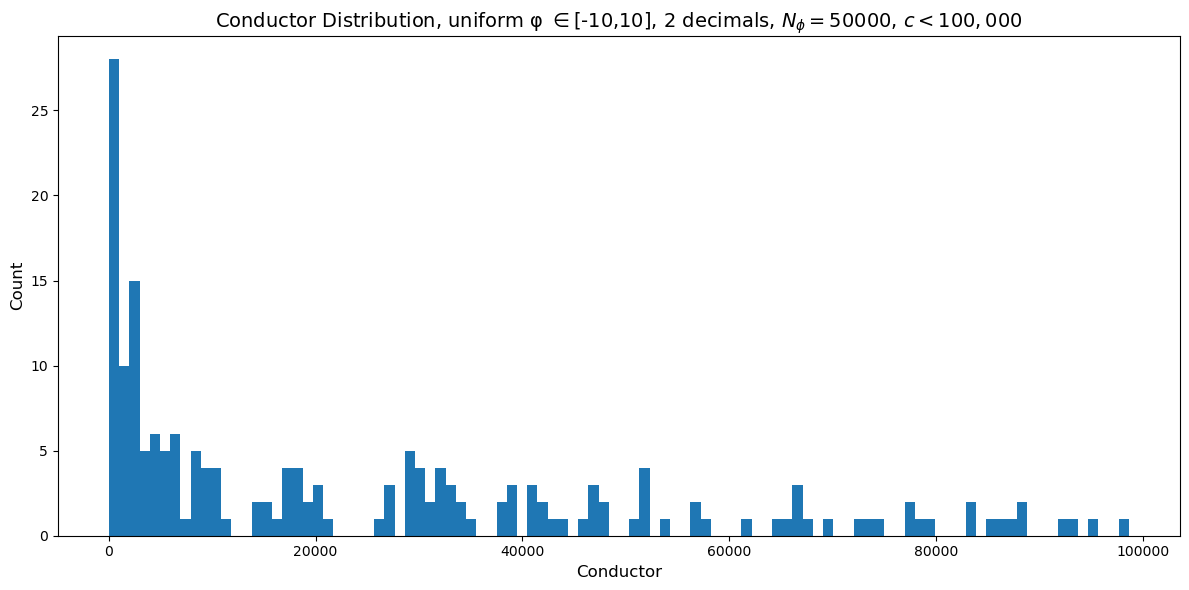


SUMMARY
φ sampling: uniform in [-10, 10], rounded to 2 decimals
Number of φ samples: 50000
Total unique phis: 2001
Unique isogeny classes found: 187
Success rate: 9.35%
Conductor range: [14, 98670]
Saved plot: HV_curves_uniform/Nphi50000_phirange_-10_10_round2_phi_distribution.png


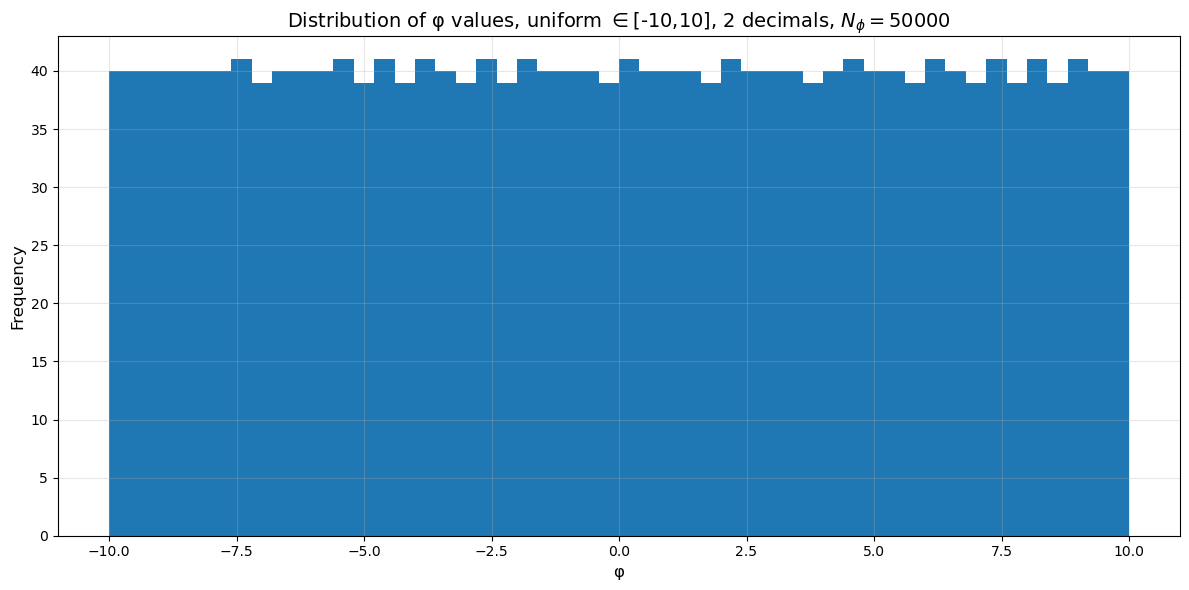

Saved plot: HV_curves_uniform/Nphi50000_phirange_-10_10_round2_conductor_vs_phi.png


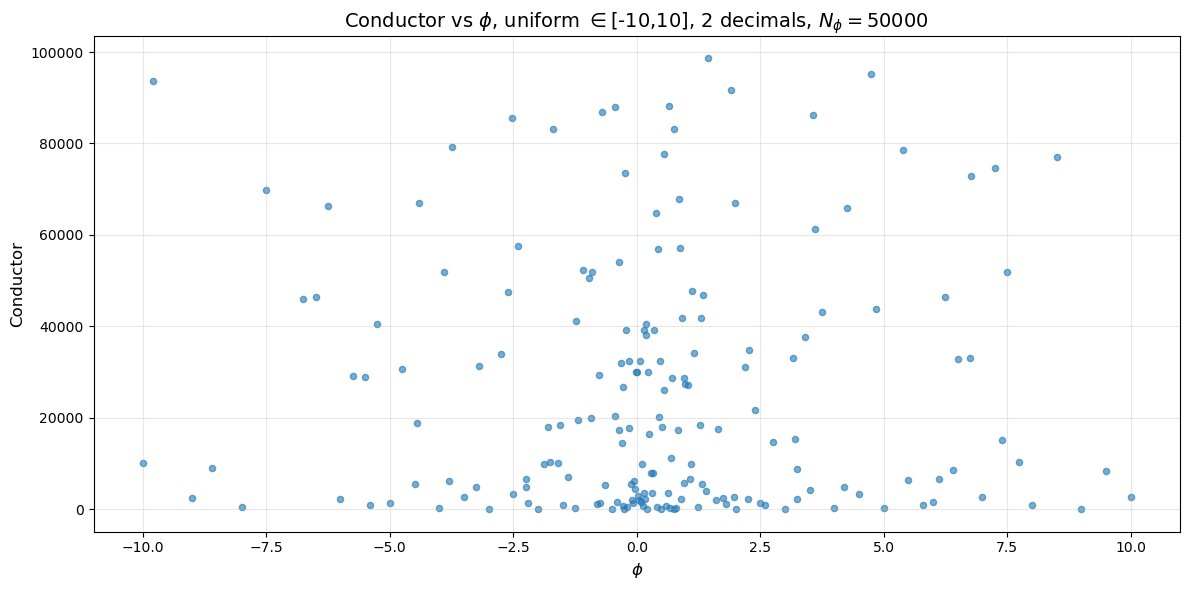

Loading aps: 100%|████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 249788.17it/s]

Averaging the aps...
Done.

Rank 0: 95 isogeny classes
Rank 1: 85 isogeny classes
Rank 2: 7 isogeny classes
Rank 3: 0 isogeny classes

Saved average aps to HV_curves_uniform/Nphi50000_phirange_-10_10_round2_average_aps.sobj
Skipped rank 0 vs rank 1 plot: insufficient data (need at least 100 curves per rank)
Skipped all ranks plot: would be identical to rank 0 vs rank 1 plot

No ranks with sufficient statistics to plot

SUMMARY
φ sampling: uniform in [-10, 10], rounded to 2 decimals
Number of φ samples: 50000
Unique φ after rounding: 2001
Unique isogeny classes found: 187
Rank distribution:
  Rank 0: 95
  Rank 1: 85
  Rank 2: 7
  Rank 3: 0


In [23]:
# Generate phi uniformly

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool, cpu_count
import os

# Check that curve_db is loaded
try:
    curve_db
    print(f"✓ curve_db is loaded with {len(curve_db)} isogeny classes")
except NameError:
    raise NameError("curve_db is not loaded! Please load the database first using:\n"
                    "  curve_db = load('path/to/curve_database.sobj')")
print()

def phi_to_isogeny_class(phi):
    """
    Given a parameter φ, compute the corresponding elliptic curve
    and return its isogeny class label.
    
    Parameters:
    -----------
    phi : numeric
        The parameter φ (should result in a curve over Q)
    
    Returns:
    --------
    str : The isogeny class label (e.g., '37a')
    
    Raises:
    -------
    ValueError : If the curve is not defined over Q or has no Cremona label
    """
    from sage.all import EllipticCurve, QQ
    
    # Compute Weierstrass coefficients from phi (equation 70)
    a_numerator = 9*phi**4 - 12*phi**3 + 30*phi**2 - 12*phi + 1
    a = -a_numerator / 3
    
    b_numerator = 27*phi**6 - 54*phi**5 - 135*phi**4 + 180*phi**3 - 99*phi**2 + 18*phi - 1
    b = -2 * b_numerator / 27
    
    # Create elliptic curve
    E = EllipticCurve([0, 0, 0, a, b])
    
    # Ensure we're working over Q
    try:
        E_Q = E.change_ring(QQ)
    except (TypeError, ValueError):
        raise ValueError(f"Curve from φ={phi} is not defined over Q")
    
    # Convert to minimal model
    E_min = E_Q.minimal_model()
    
    # Get the Cremona label
    try:
        label = E_min.label()
    except (RuntimeError, LookupError) as e:
        raise ValueError(f"Could not find Cremona label for curve from φ={phi}: {e}")
    
    # Extract isogeny class from label (e.g., '37a2' -> '37a')
    i = len(label) - 1
    while i >= 0 and label[i].isdigit():
        i -= 1
    isogeny_class = label[:i+1]
    
    return isogeny_class

def generate_phi_chunk(args):
    """Generate a chunk of random phi values"""
    chunk_size, phimin, phimax, phi_round_digits, seed = args
    np.random.seed(seed)
    chunk = np.random.random(chunk_size) * (phimax - phimin) + phimin
    return [QQ(round(x, phi_round_digits)) for x in chunk]

def process_phi(phi):
    """Worker function to process a single phi value"""
    try:
        iso = phi_to_isogeny_class(phi)
        
        # Look up in database by isogeny class
        curve = curve_db[iso]
        c = curve['conductor']
        
        return (phi, c, iso)
    except:
        return None

Nphi = 50000
phimin = -10
phimax = 10
phi_round_digits = 2

# Create filename suffix with phi range and rounding
phi_range_str = f"phirange_{phimin}_{phimax}_round{phi_round_digits}"

print("Generating initial phi set in parallel...")
print(f"Using {cpu_count()} CPU cores")

# Split work across cores
num_cores = cpu_count()
chunk_size = Nphi // num_cores
chunks = [(chunk_size, phimin, phimax, phi_round_digits, i) for i in range(num_cores)]

# Generate phis in parallel
with Pool(processes=num_cores) as pool:
    phi_chunks = list(tqdm(
        pool.imap(generate_phi_chunk, chunks),
        total=len(chunks),
        desc="Generating phis"
    ))

# Flatten the list of lists
phis = [phi for chunk in phi_chunks for phi in chunk]

print(f"Initial phi set: {len(phis)} (redundant) rational values")

# Remove duplicates
phis = list(set(phis))
print(f"After removing duplicates: {len(phis)} unique rational values")

# Parallelize the processing
print(f"\nProcessing phis...")
with Pool(processes=cpu_count()) as pool:
    results = list(tqdm(
        pool.imap(process_phi, phis),
        total=len(phis),
        desc="Loading conductors"
    ))

# Filter out None results and keep only unique isogeny classes
cs = []
seen_iso_classes = []
phi_reps = []
for result in results:
    if result is not None:
        phi, c, iso = result
        if iso not in seen_iso_classes:
            cs.append(c)
            seen_iso_classes.append(iso)
            phi_reps.append(phi)

print(f"Found {len(phi_reps)} phis in database below 100,000 conductors, associated to distinct isogeny classes")

# Create output directory
os.makedirs('HV_curves_uniform/', exist_ok=True)

# Save the results
print("\nSaving results...")
scan_data = {
    'phi_reps': phi_reps,
    'conductors': cs,
    'isogeny_classes': seen_iso_classes,
    'total_phis_generated': len(phis),
    'total_found': len(phi_reps),
    'Nphi': Nphi,
    'phimin': phimin,
    'phimax': phimax,
    'phi_round_digits': phi_round_digits
}

save(scan_data, f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_phi_scan_data.sobj')
print(f"Saved scan data to HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_phi_scan_data.sobj")

# Save individual lists
save(phi_reps, f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_phi_reps.sobj')
save(cs, f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_conductors.sobj')
save(seen_iso_classes, f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_isogeny_classes.sobj')

print("Saved individual lists:")
print(f"  - HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_phi_reps.sobj")
print(f"  - HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_conductors.sobj")
print(f"  - HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_isogeny_classes.sobj")

# Create conductor histogram
plt.figure(figsize=(12, 6))
plt.hist(cs, bins=100)
plt.xlabel("Conductor", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(fr"Conductor Distribution, uniform φ $\in$[{phimin},{phimax}], {phi_round_digits} decimals, $N_\phi={Nphi}$, $c<100,000$", fontsize=14)
plt.tight_layout()
plt.savefig(f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_conductor_distribution.png', dpi=150)
print(f"\nSaved plot: HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_conductor_distribution.png")
plt.show()
plt.close()

# Print summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"φ sampling: uniform in [{phimin}, {phimax}], rounded to {phi_round_digits} decimals")
print(f"Number of φ samples: {Nphi}")
print(f"Total unique phis: {len(phis)}")
print(f"Unique isogeny classes found: {len(phi_reps)}")
print(f"Success rate: {int(100)*len(phi_reps)/len(phis):.2f}%")
print(f"Conductor range: [{min(cs)}, {max(cs)}]")
print("="*60)

# Plot phi distribution
phis_float = [float(phi) for phi in phis]

plt.figure(figsize=(12, 6))
plt.hist(phis_float, bins=50)
plt.xlabel('φ', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Distribution of φ values, uniform $\\in$[{phimin},{phimax}], {phi_round_digits} decimals, $N_\\phi={Nphi}$', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_phi_distribution.png', dpi=150)
print(f"Saved plot: HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_phi_distribution.png")
plt.show()
plt.close()

# Plot conductor vs phi
plt.figure(figsize=(12, 6))
plt.scatter(phi_reps, cs, alpha=0.6, s=20)
plt.xlabel(r"$\phi$", fontsize=12)
plt.ylabel("Conductor", fontsize=12)
plt.title(fr"Conductor vs $\phi$, uniform $\in$[{phimin},{phimax}], {phi_round_digits} decimals, $N_\phi={Nphi}$", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_conductor_vs_phi.png', dpi=150)
print(f"Saved plot: HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_conductor_vs_phi.png")
plt.show()
plt.close()

# Extract aps, plot the results and save results

# Extract average aps sorted by rank
rk0_aps = []
rk1_aps = []
rk2_aps = []
rk3_aps = []
for iso in tqdm(seen_iso_classes, desc="Loading aps: "):
    curve = curve_db[iso]
    rk = curve['rank']
    aps = curve['ap_list']
    if rk == 0:
        rk0_aps.append(aps)
    elif rk == 1:
        rk1_aps.append(aps)
    elif rk == 2:
        rk2_aps.append(aps)
    elif rk == 3:
        rk3_aps.append(aps)

# Convert to numpy arrays
rk0_aps = np.array(rk0_aps) if len(rk0_aps) > 0 else None
rk1_aps = np.array(rk1_aps) if len(rk1_aps) > 0 else None
rk2_aps = np.array(rk2_aps) if len(rk2_aps) > 0 else None
rk3_aps = np.array(rk3_aps) if len(rk3_aps) > 0 else None

print("Averaging the aps...")
rk0_average_aps = np.mean(rk0_aps, axis=0) if rk0_aps is not None else None
rk1_average_aps = np.mean(rk1_aps, axis=0) if rk1_aps is not None else None
rk2_average_aps = np.mean(rk2_aps, axis=0) if rk2_aps is not None else None
rk3_average_aps = np.mean(rk3_aps, axis=0) if rk3_aps is not None else None
print("Done.")

# Print statistics
print(f"\nRank 0: {len(rk0_aps) if rk0_aps is not None else 0} isogeny classes")
print(f"Rank 1: {len(rk1_aps) if rk1_aps is not None else 0} isogeny classes")
print(f"Rank 2: {len(rk2_aps) if rk2_aps is not None else 0} isogeny classes")
print(f"Rank 3: {len(rk3_aps) if rk3_aps is not None else 0} isogeny classes")

# Save the data
averages_data = {
    'rank_0_average': rk0_average_aps.tolist() if rk0_average_aps is not None else None,
    'rank_1_average': rk1_average_aps.tolist() if rk1_average_aps is not None else None,
    'rank_2_average': rk2_average_aps.tolist() if rk2_average_aps is not None else None,
    'rank_3_average': rk3_average_aps.tolist() if rk3_average_aps is not None else None,
    'rank_0_count': len(rk0_aps) if rk0_aps is not None else 0,
    'rank_1_count': len(rk1_aps) if rk1_aps is not None else 0,
    'rank_2_count': len(rk2_aps) if rk2_aps is not None else 0,
    'rank_3_count': len(rk3_aps) if rk3_aps is not None else 0,
    'phi_reps': phi_reps,
    'isogeny_classes': seen_iso_classes,
    'conductors': cs,
    'Nphi': Nphi,
    'phi_round_digits': phi_round_digits
}

save(averages_data, f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_average_aps.sobj')
print(f"\nSaved average aps to HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_average_aps.sobj")

# Save individual arrays
if rk0_average_aps is not None:
    save(rk0_average_aps, f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_rk0_average_aps.sobj')
if rk1_average_aps is not None:
    save(rk1_average_aps, f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_rk1_average_aps.sobj')
if rk2_average_aps is not None:
    save(rk2_average_aps, f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_rk2_average_aps.sobj')
if rk3_average_aps is not None:
    save(rk3_average_aps, f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_rk3_average_aps.sobj')

# Create plots
N = len(rk0_average_aps) if rk0_average_aps is not None else (
     len(rk1_average_aps) if rk1_average_aps is not None else 0)

# Define minimum sample size for plotting
MIN_SAMPLES = 100

if N > 0:
    # Plot 1: Rank 0 vs Rank 1
    plt.figure(figsize=(14, 7))
    plot_count_rk01 = 0
    if rk0_aps is not None and len(rk0_aps) >= MIN_SAMPLES:
        plt.scatter(range(N), rk0_average_aps, 
                   label=f"Rank 0 (n={len(rk0_aps)})", alpha=0.6, s=15)
        plot_count_rk01 += 1
    if rk1_aps is not None and len(rk1_aps) >= MIN_SAMPLES:
        plt.scatter(range(N), rk1_average_aps, 
                   label=f"Rank 1 (n={len(rk1_aps)})", alpha=0.6, s=15)
        plot_count_rk01 += 1
    
    if plot_count_rk01 > 0:
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        plt.legend(fontsize=12)
        plt.xlabel(r"Prime index $i$", fontsize=12)
        plt.ylabel(r"Average $a_{p_i}$", fontsize=12)
        plt.title(fr"Average $a_p$ vs prime index, uniform φ $\in$[{phimin},{phimax}], {phi_round_digits} decimals, $N_\phi={Nphi}$", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_ap_averages_rank0_vs_rank1.png', dpi=150)
        print(f"Saved plot: HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_ap_averages_rank0_vs_rank1.png")
        plt.show()
    else:
        print(f"Skipped rank 0 vs rank 1 plot: insufficient data (need at least {MIN_SAMPLES} curves per rank)")
    plt.close()
    
    # Check if we have additional ranks beyond 0 and 1
    has_additional_ranks = False
    if rk2_aps is not None and len(rk2_aps) >= MIN_SAMPLES:
        has_additional_ranks = True
    if rk3_aps is not None and len(rk3_aps) >= MIN_SAMPLES:
        has_additional_ranks = True
    
    # Plot 2: All ranks (only if different from rank 0 vs rank 1)
    if has_additional_ranks:
        plt.figure(figsize=(14, 7))
        plot_count_all = 0
        if rk0_aps is not None and len(rk0_aps) >= MIN_SAMPLES:
            plt.scatter(range(N), rk0_average_aps, 
                       label=f"Rank 0 (n={len(rk0_aps)})", alpha=0.5, s=12)
            plot_count_all += 1
        if rk1_aps is not None and len(rk1_aps) >= MIN_SAMPLES:
            plt.scatter(range(N), rk1_average_aps, 
                       label=f"Rank 1 (n={len(rk1_aps)})", alpha=0.5, s=12)
            plot_count_all += 1
        if rk2_aps is not None and len(rk2_aps) >= MIN_SAMPLES:
            plt.scatter(range(N), rk2_average_aps, 
                       label=f"Rank 2 (n={len(rk2_aps)})", alpha=0.5, s=12)
            plot_count_all += 1
        if rk3_aps is not None and len(rk3_aps) >= MIN_SAMPLES:
            plt.scatter(range(N), rk3_average_aps, 
                       label=f"Rank 3 (n={len(rk3_aps)})", alpha=0.5, s=12)
            plot_count_all += 1
        
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        plt.legend(fontsize=12)
        plt.xlabel(r"Prime index $i$", fontsize=12)
        plt.ylabel(r"Average $a_{p_i}$", fontsize=12)
        plt.title(fr"Average $a_p$ by rank, uniform φ $\in$[{phimin},{phimax}], {phi_round_digits} decimals, $N_\phi={Nphi}$", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_ap_averages_all_ranks.png', dpi=150)
        print(f"Saved plot: HV_curves_uniform/Nphi{Nphi}_{phi_range_str}_ap_averages_all_ranks.png")
        plt.show()
        plt.close()
    else:
        print(f"Skipped all ranks plot: would be identical to rank 0 vs rank 1 plot")
    
    if plot_count_rk01 > 0 or has_additional_ranks:
        print("\nDone!")
    else:
        print("\nNo ranks with sufficient statistics to plot")
else:
    print("\nNo data to plot")

# Print final summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"φ sampling: uniform in [{phimin}, {phimax}], rounded to {phi_round_digits} decimals")
print(f"Number of φ samples: {Nphi}")
print(f"Unique φ after rounding: {len(phis)}")
print(f"Unique isogeny classes found: {len(seen_iso_classes)}")
print(f"Rank distribution:")
print(f"  Rank 0: {len(rk0_aps) if rk0_aps is not None else 0}")
print(f"  Rank 1: {len(rk1_aps) if rk1_aps is not None else 0}")
print(f"  Rank 2: {len(rk2_aps) if rk2_aps is not None else 0}")
print(f"  Rank 3: {len(rk3_aps) if rk3_aps is not None else 0}")
print("="*60)

Student-t normalized fit: x0=0.335, sigma=1.208, nu=0.366
Saved fit parameters: HV_curves_uniform/Nphi1000000_tfit_params.txt
Saved plot: HV_curves_uniform/Nphi1000000_phi_reps_distribution_tfit_norm.png


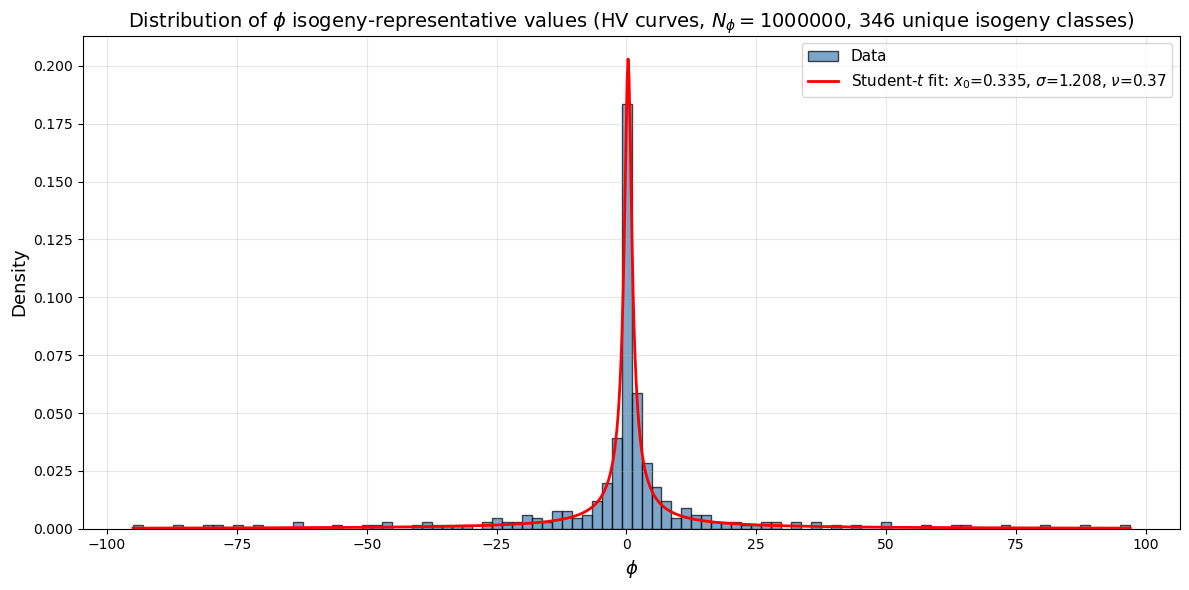

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma

# Convert to float
phi_reps_float = [float(x) for x in phi_reps]

plt.figure(figsize=(12, 6))

# Create normalized histogram
counts, bins, _ = plt.hist(
    phi_reps_float, bins=100, density=True,
    edgecolor='black', alpha=0.7, color='steelblue',
    label='Data'
)

# ---------- Normalized Student's t distribution ----------
def student_t_norm(x, x0, sigma, nu):
    """Normalized symmetric Student-t PDF."""
    norm = gamma((nu + 1) / 2) / (np.sqrt(nu * np.pi) * sigma * gamma(nu / 2))
    return norm * (1 + ((x - x0)**2) / (nu * sigma**2)) ** (-(nu + 1) / 2)

# Compute bin centers for fitting
bin_centers = 0.5 * (bins[:-1] + bins[1:])
mask = counts > 0

# Initial guesses
x0_guess = np.mean(phi_reps_float)
sigma_guess = np.std(phi_reps_float)
nu_guess = 2.0  # moderate tails

try:
    popt, pcov = curve_fit(
        student_t_norm,
        bin_centers[mask],
        counts[mask],
        p0=[x0_guess, sigma_guess, nu_guess],
        bounds=([-np.inf, 1e-6, 0.1], [np.inf, np.inf, 100]),
        maxfev=20000
    )
    x0_fit, sigma_fit, nu_fit = popt

    # Generate fitted curve
    x_fit = np.linspace(min(phi_reps_float), max(phi_reps_float), 1000)
    y_fit = student_t_norm(x_fit, x0_fit, sigma_fit, nu_fit)

    # Plot fit with parameters in legend
    plt.plot(
        x_fit, y_fit, 'r-', linewidth=2,
        label=(
            r"Student-$t$ fit: "
            fr"$x_0$={x0_fit:.3f}, $\sigma$={sigma_fit:.3f}, $\nu$={nu_fit:.2f}"
        )
    )

    print(f"Student-t normalized fit: x0={x0_fit:.3f}, sigma={sigma_fit:.3f}, nu={nu_fit:.3f}")

    # Save fit parameters
    params_path = f'HV_curves_uniform/Nphi{Nphi}_tfit_params.txt'
    with open(params_path, 'w') as f:
        f.write("Student-t normalized fit parameters\n")
        f.write(f"x0 = {x0_fit:.6f}\n")
        f.write(f"sigma = {sigma_fit:.6f}\n")
        f.write(f"nu = {nu_fit:.6f}\n")
    print(f"Saved fit parameters: {params_path}")

except Exception as e:
    print(f"Student-t fit failed: {e}")

# Labels and title
plt.xlabel(r'$\phi$', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title(
    fr'Distribution of $\phi$ isogeny-representative values '
    fr'(HV curves, $N_\phi={Nphi}$, {len(phi_reps)} unique isogeny classes)',
    fontsize=14
)

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
save_path = f'HV_curves_uniform/Nphi{Nphi}_phi_reps_distribution_tfit_norm.png'
plt.savefig(save_path, dpi=150)
print(f"Saved plot: {save_path}")

plt.show()


In [24]:
uniform_iso = load("HV_curves_uniform/Nphi1000000_isogeny_classes.sobj")
fraction_iso_data = load("HV_curves/(-500,500)_average_aps.sobj")
fraction_iso = mn_iso_data['isogeny_classes']

print(len(uniform_iso),len(fraction_iso),len(uniform_iso)+len(fraction_iso))

tot_iso = list(set(fraction_iso + uniform_iso))

len(tot_iso)
# This shows that all isogeny classes found by uniform sampling of phi are contained in the ones
# found with fraction sampling

346 1296 1642


1296